In [1]:
import pandas as pd
import numpy as np
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
from sklearn import tree
from sklearn.model_selection import cross_val_score
from pymop import Problem
import optuna
import os
from tslearn.datasets import UCR_UEA_datasets

## Data

In [2]:
#TODO Betriebsystem unterscheidung
import pickle
from pathlib import Path
import platform
from data.DataLoader import load_UCR_dataset
os_type= platform.system()

dataset='GunPoint'
X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x=X_train
test_x=X_test
enc1=pickle.load(open(f'./models/{dataset}/OneHotEncoder.pkl','rb'))
test_y=enc1.transform(test_y.reshape(-1,1))
train_y=enc1.transform(train_y.reshape(-1,1))

## Train Model

In [3]:
import sklearn
def fit_classifier(classifier, x_train,y_train, x_test,y_test):


    nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))

    # transform the labels from integers to one hot vectors
    enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
    y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

    # save orignal y because later we will use binary
    y_true = np.argmax(y_test, axis=1)

    if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    input_shape = x_train.shape[1:]

    classifier.fit(x_train, y_train, x_test, y_test, y_true)

In [4]:
from models.CNN_Tens import Classifier_CNN
import tensorflow as tf 
#print(train_x.shape[1])
#print(train_x.shape[2])
if any(fname.endswith('.h5') for fname in os.listdir(f'./models/{dataset}/')):# '.h5' in os.listdir(f'./models/{dataset}/'):
    #TODO only if file ends with 
    model = Classifier_CNN(f'./models/{dataset}/', (train_x.shape[1], train_x.shape[2]), 2,verbose=True)
    fit_classifier(model, train_x,train_y,test_x,test_y)
else:
    
    model=tf.keras.models.load_model(f'./models/{dataset}/best_model.hdf5')

In [5]:
test_preds= model.predict(test_x)
ground_truth=np.argmax(test_y,axis=1)

<AxesSubplot:>

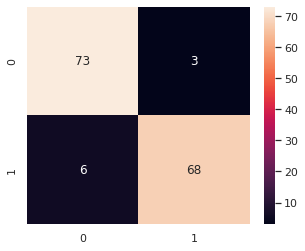

In [6]:
sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, np.argmax(test_preds,axis=1))
sns.heatmap(heatmap, annot=True)

In [7]:
accuracy_score(ground_truth, np.argmax(test_preds,axis=1))

0.94

## MOC


In [8]:
from TSEvo.CounterfactualExplanation import Explanation
exp =Explanation(model= model,data=(test_x,test_y), backend='tf')

y was one Hot Encoded


In [9]:
pop,logbook=exp.explain_instance(test_x[0],np.array([test_y[0]]))

Reference Set not Target
y (150,)
y [0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1
 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1
 1 0]
original (1, 2)
0
ReferenceSet class [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Reference Set from Explanation (74, 150, 1)
(1, 1, 150)
Binary Case
Predict TF
   	   	     	                  stats_y_distance                 	              stats_x_distance             	       stats_changed_features      
   	   	     	---------------------------------------------------	-------------------------------------------	-----------------------------------
gen	pop	evals	std     	min        	avg     	max	std    	min      	avg     	max	std    	min      	av

In [10]:
pop_ = [ind[0][0] for ind in pop]
print(np.array(pop).shape)

(1, 1, 150)


In [11]:
# extract statistics:
meanYDistance = logbook.chapters['stats_y_distance'].select("min")
#logbook.chapters['stats_y_distance','stats_x_distance','stats_changed_features','stats_gower'].select("avg")
meanXDistance = logbook.chapters['stats_x_distance'].select("min")
meanChanged = logbook.chapters['stats_changed_features'].select("min")
meanGower = logbook.chapters['stats_gower'].select("min")

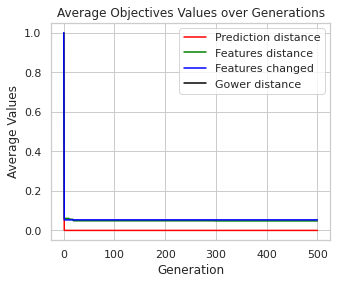

In [12]:
# plot statistics:
sns.set_style("whitegrid")
plt.plot(meanYDistance, color='red', label='Prediction distance')
plt.plot(meanXDistance, color='green', label='Features distance')
plt.plot(meanChanged, color='blue', label='Features changed')
plt.plot(meanGower, color='black', label='Gower distance')
plt.xlabel('Generation')
plt.ylabel('Average Values')
plt.title('Average Objectives Values over Generations')
plt.set_loglevel
plt.legend()
plt.show() 

(150, 1)


<AxesSubplot:label='f6589b8b-d88b-4e32-bff1-ac96ebd260be'>

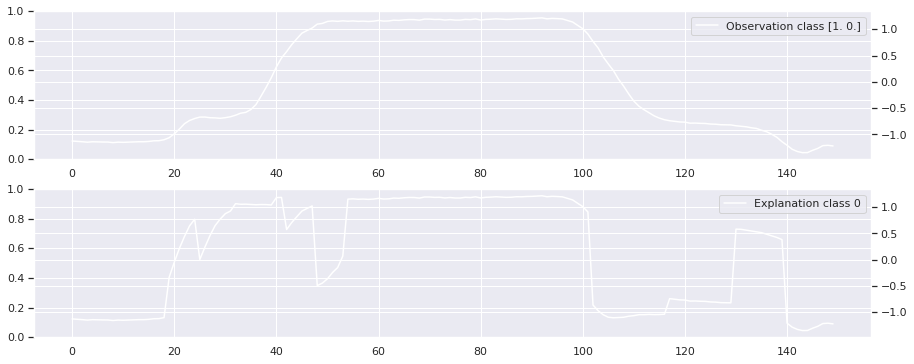

In [13]:
#df_01 = get_saliency_map_filter(observation_x, observation_y)
#df_02 = get_saliency_map_filter(pop_4, target_y)
observation_x= test_x[0]
observation_y=test_y[0]
print(np.array(observation_x).shape) 
#sal_01 = get_saliency_map(observation_x)
#print(np.array(pop)[4][0].shape)
#sal_02 = get_saliency_map(pop_[4])
#sal_02= get_saliency_map(np.array(pop)[0][0])
sns.set(rc={'figure.figsize':(15,6)})

ax011 = plt.subplot(211)
ax012 = ax011.twinx()
ax021 = plt.subplot(212)
ax022 = ax021.twinx()
individual = np.array(pop[0], dtype=np.float64)
#input_ = torch.from_numpy(individual).float().reshape(1,1,150)
output = model.predict(observation_x.reshape(1,-1,1))
idx = output.argmax()
#sns.heatmap(sal_01, fmt="g", cmap='viridis', cbar=False, ax=ax011, yticklabels=False)
sns.lineplot(x=range(150), y=observation_x.flatten(), label='Observation class ' + str(observation_y), color='white', ax=ax012)
target_y= 'Not Yet '
#sns.heatmap(sal_02, fmt="g", cmap='viridis', cbar=False, ax=ax021, yticklabels=False)
sns.lineplot(x=range(150), y=np.array(pop)[0][0].flatten(), label='Explanation class ' + str(idx), color='white', ax=ax022)

(1, 150)


<AxesSubplot:label='c92bb83d-e08f-450c-8a5c-93c82877edac'>

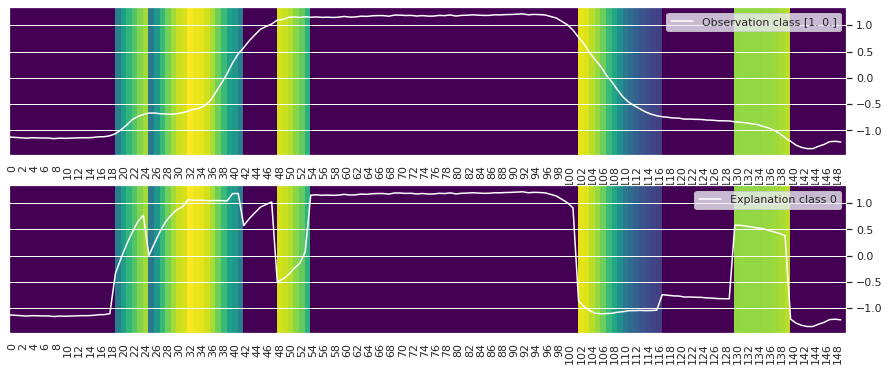

In [14]:
#TODO  Visualize Identical and different points 
ax011 = plt.subplot(211)
ax012 = ax011.twinx()
ax021 = plt.subplot(212)
ax022 = ax021.twinx()
individual = np.array(pop[0], dtype=np.float64)
#input_ = torch.from_numpy(individual).float().reshape(1,1,150)
#output = torch.nn.functional.softmax(model(input_)).detach().numpy()
#idx = output.argmax()
sal_01= np.abs(observation_x.reshape(-1)-np.array(pop)[0][0].reshape(-1)).reshape(1,-1)
print(sal_01.shape)
sns.heatmap(sal_01, fmt="g", cmap='viridis', cbar=False, ax=ax011, yticklabels=False)
sns.lineplot(x=range(150), y=observation_x.flatten(), label='Observation class ' + str(observation_y), color='white', ax=ax012)
target_y= 'Not Yet '
sns.heatmap(sal_01, fmt="g", cmap='viridis', cbar=False, ax=ax021, yticklabels=False)
sns.lineplot(x=range(150), y=np.array(pop)[0][0].flatten(), label='Explanation class ' + str(idx), color='white', ax=ax022)